In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


In [127]:
# transform data into lstm inputs
def rnn_data(df, inp_cols, out_cols, look_back = 0, look_ahead = 0, output_seq=False, dtype=np.float32, test_split=0.1):
    # get the raw input data from data frame
    xraw = df[inp_cols].values
    # get the raw output data from data frame
    yraw = df[out_cols].values
    # get the time stamps for the raw data
    traw = df.index
    
    # the number of complete samples available
    n = len(df)-look_back-look_ahead-1
    
    xdata = np.zeros((n, look_back+1, xraw.shape[1]))
    ydata = np.zeros((n, look_ahead+1, yraw.shape[1]))
    tx = np.zeros((n, look_back+1), dtype=traw.dtype)
    ty = np.zeros((n, look_ahead+1), dtype=traw.dtype)
    
    # time separation [start(inclusive): end(exclusive)] 
    # input data  x[j-look_back : j+1]           , length=look_back+1
    # output data y[j+1         : j+look_ahead+2], length=look_ahead+1
    for i in range(n):
        lb = range(i, i+look_back+1)
        xdata[i,:,:] = xraw[lb,:]
        tx[i,:] = traw[lb]
    for i in range(n):
        la = range(i+look_back+1, i+look_back+look_ahead+2)
        ydata[i,:,:] = yraw[la,:]
        ty[i,:] = traw[la]

    assert(len(xdata.shape)==3)
    assert(xdata.shape[0] == xraw.shape[0]-look_ahead-look_back-1)
    assert(xdata.shape[2] == xraw.shape[1])
    assert(xdata.shape[1]==look_back+1)
    assert(len(ydata.shape)==3)
    assert(ydata.shape[0] == yraw.shape[0]-look_ahead-look_back-1)
    assert(ydata.shape[2] == yraw.shape[1])
    assert(ydata.shape[1] == look_ahead+1)
    
    if not output_seq and ydata.shape[2]==1:
        ydata = ydata.squeeze(axis=2)
    else:
        mlen = max(xdata.shape[1], ydata.shape[1])
        xdata = pad_sequences(xdata, mlen, padding='post', dtype='float32')
        tx = pad_sequences(tx, mlen, padding='post', dtype='float32')
        ydata = pad_sequences(ydata, mlen, padding='pre', dtype='float32')
        ty = pad_sequences(ty, mlen, padding='pre', dtype='float32')

    assert(test_split>=0 and test_split<=1)
    ntrain = round(n*(1-test_split))    
        
    return xdata[:ntrain].astype(dtype), ydata[:ntrain].astype(dtype), tx[:ntrain], ty[:ntrain], \
        xdata[ntrain:].astype(dtype), ydata[ntrain:].astype(dtype), tx[ntrain:], ty[ntrain:]

In [148]:
# create fake data
Fs = 100
f = 5
sample = 1000
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)

df = pd.DataFrame(y)
df.columns = ['f1']
df.index = pd.date_range('1/1/2017', periods=df.shape[0], freq='1s')

xtrain, ytrain, txtrain, tytrain, \
    xtest, ytest, txtest, tytest = rnn_data(df, ['f1'], ['f1'], look_back=20, look_ahead=20)
print(xtrain.shape, ytrain.shape, xtest.shape, ytest.shape)

(863, 21, 1) (863, 21) (96, 21, 1) (96, 21)


In [149]:
# build keras model
stateful = False # stateful not complete yet
batch_size = 100

model = Sequential()
if not stateful and len(ytrain.shape)==3:
    # using sequence output, y-data has dim=3
    model.add(LSTM(input_shape=(xtrain.shape[1], xtrain.shape[2]), units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(Dense(ytrain.shape[2]))
    model.add(Activation("linear"))
elif not stateful:
    # not using sequence output, y-data has dim=2
    model.add(LSTM(input_shape=(xtrain.shape[1], xtrain.shape[2]), units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(ytrain.shape[1]))
    model.add(Activation("linear"))
elif len(ytrain.shape)==3:
    # stateful: using sequence output, y-data has dim=3
    model.add(LSTM(input_shape=(xtrain.shape[1], xtrain.shape[2]), batch_size=batch_size, units=50, return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(ytrain.shape[2]))
    model.add(Activation("linear"))    
else:    
    # stateful: not using sequence output, y-data has dim=2
    model.add(LSTM(input_shape=(xtrain.shape[1], xtrain.shape[2]), batch_size=batch_size, units=50, return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=False, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(ytrain.shape[1]))
    model.add(Activation("linear"))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 21, 50)            10400     
_________________________________________________________________
dropout_55 (Dropout)         (None, 21, 50)            0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_56 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 21)                2121      
_________________________________________________________________
activation_28 (Activation)   (None, 21)                0         
Total params: 72,921
Trainable params: 72,921
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train model on data
model.fit(xtrain, ytrain, epochs=10, batch_size=batch_size, validation_split=0.1)

Train on 776 samples, validate on 87 samples
Epoch 1/10
776/776 [==============================] - 5s - loss: 0.4662 - val_loss: 0.4138
Epoch 2/10
776/776 [==============================] - 0s - loss: 0.3331 - val_loss: 0.1691
Epoch 3/10
776/776 [==============================] - 0s - loss: 0.1179 - val_loss: 0.0549
Epoch 4/10
776/776 [==============================] - 0s - loss: 0.0478 - val_loss: 0.0124
Epoch 5/10
776/776 [==============================] - 0s - loss: 0.0290 - val_loss: 0.0066
Epoch 6/10
776/776 [==============================] - 0s - loss: 0.0244 - val_loss: 0.0026
Epoch 7/10
776/776 [==============================] - 0s - loss: 0.0203 - val_loss: 0.0025
Epoch 8/10
600/776 [======================>.......] - ETA: 0s - loss: 0.0171

In [146]:
# make the predictions
ypred = model.predict(xtest, batch_size=batch_size)

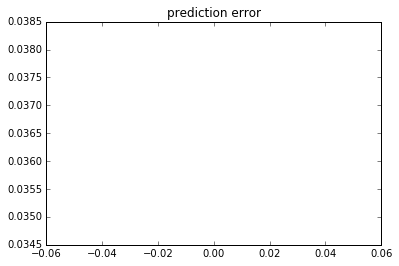

In [147]:
plt.plot(np.mean(np.power(ytest.squeeze()-ypred.squeeze(),2),axis=0));
plt.title('prediction error');

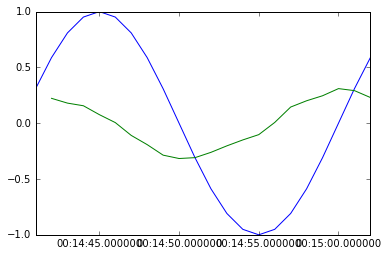

In [139]:
# plotting the prediction, first sample
plt.plot(txtest[0:ytest.shape[1]+1,-1], xtest[0:ytest.shape[1]+1,-1,0]);
plt.plot(tytest[0,:], ypred[0,:]);
plt.plot(txtest[0,:], xtest[0,:]);

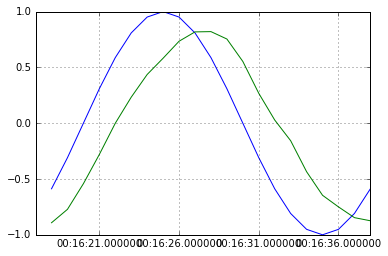

In [140]:
# plotting the prediction, last sample
ytmp = model.predict(xtest[-2:-1,:,:])
plt.plot(tytest[-2:-1,:].squeeze(), ytest[-2:-1,:].squeeze())
plt.plot(tytest[-2:-1,:].squeeze(), ytmp.squeeze())
plt.plot(txtest[-2:-1,:].squeeze(), xtest[-2:-1,:,:].squeeze())
plt.grid()